# Library and data imports
1. [**Getting to know the data**](#Getting-to-know-the-data) - [Inside Information](#Some-findings-and-reasonings)
2. [**Preprocessing the data**](#Preprocessing-the-data) - [Obliterate the Data](#Some-findings-and-reasonings)
3. [**Getting some basic information from the data**](#Getting-some-basic-information-from-the-data) - [Scratching the surface](#Some-findings-and-reasonings)
4. [**Detailed analysis**](#Lets-Dig-Deep) - [Click Here for detailed secrets](#Some-findings-and-reasonings)


Assumptions:
1. Assuming that the highest closer, i.e. most calls done by a agent, is actually the best agent. Therefore other agents are mesured against the best.
2. Assuming longer talk hours means successful partnership

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import bokeh as bk
from celluloid import Camera
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

%matplotlib inline

def read_data():
    df = pd.read_csv("data.csv")
    return df

df = read_data()
df.head(2)

,id,created,createdById,created_at,duration,isIncoming,outcome,lead_created_at,personId,userId,left_a_note
0,2163,2017-12-31T18:41:06Z,88,2017-12-31 12:41:06-06:00,0,False,NaN,2017-12-31 11:03:40-06:00,129570,88,1
1,11268,2018-02-08T21:07:24Z,57,2018-02-08 15:07:24-06:00,0,False,NaN,2017-12-31 11:19:21-06:00,129572,57,1


# Getting to know the data

In [2]:
df.isnull().sum()

id                      0
created                 0
createdById             0
created_at              0
duration                0
isIncoming              0
outcome            155175
lead_created_at         0
personId                0
userId                  0
left_a_note             0
dtype: int64

In [3]:
print("Number of unique leads(people): ", df["personId"].nunique())
print("Number of unique agents: ", df["userId"].nunique())

print("Number of leads handled on an average by agents: ", 
      round(df["personId"].nunique()/df["userId"].nunique()), " leads/agent")

Number of unique leads(people):  28004
Number of unique agents:  169
Number of leads handled on an average by agents:  166  leads/agent


In [4]:
print("Maximum duration of a call by a agent: ", max(df['duration'])," secs")
print("Average duration of a call by a agent: ", round(np.mean(df['duration']),2)," secs")

Maximum duration of a call by a agent:  63841  secs
Average duration of a call by a agent:  47.16  secs


In [5]:
df["left_a_note"].value_counts()

1    169120
0     11368
Name: left_a_note, dtype: int64

In [6]:
print("number of leads taking the initiative: ", df['personId'][df['isIncoming']==True].nunique())

number of leads taking the initiative:  2723


### Some findings and reasonings

# Preprocessing the data

In [7]:
df["created"] = pd.to_datetime(df["created"])
df["created_at"] = pd.to_datetime(df["created_at"], utc = True)
df["lead_created_at"] = pd.to_datetime(df["lead_created_at"], utc=True)
df["time_before_call_made"] = df["created_at"] - df["lead_created_at"]
df['call_created_year'] = df['created_at'].apply(lambda x:x.year)
df['call_created_month'] = df['created_at'].apply(lambda x:x.month)
df['call_created_hour'] = df['created_at'].apply(lambda x:x.hour)
df['lead_created_year'] = df['lead_created_at'].apply(lambda x:x.year)
df['lead_created_month'] = df['lead_created_at'].apply(lambda x:x.month)
df['lead_created_hour'] = df['lead_created_at'].apply(lambda x:x.hour)

In [8]:
df.id.nunique()

180488

In [9]:
temp_data = df.copy()
df.drop(['created', 'id', 'outcome'], axis=1, inplace=True)

### Some findings and reasonings

# Getting some basic information from the data

In [10]:
lead_list = df["personId"].unique()
agent_list = df["userId"].unique()
agent_to_lead = {}
lead_to_agent = {}
number_of_calls_by_agents = {}

for i in lead_list:
    lead_to_agent[i] = df["userId"][df["personId"]==i].nunique()
    
for i in agent_list:
    x = df[df["userId"]==i].copy()
    agent_to_lead[i] = x["personId"].nunique()
    number_of_calls_by_agents[i] = x.shape[0]

In [11]:
def check(x):
    if x.createdById!=x.userId:
        return pd.Series({"status":True,"lead_made_by":x.createdById,"lead_pursured_by":x.userId})
    else:
        return pd.Series({"status":False,"lead_made_by":np.nan,"lead_pursured_by":np.nan})
df[['status','lead_made_by','lead_pursured_by']] = df.apply(check,axis=1)

In [12]:
df['status'].value_counts()

False    109914
True      70574
Name: status, dtype: int64

# Lets Dig Deep

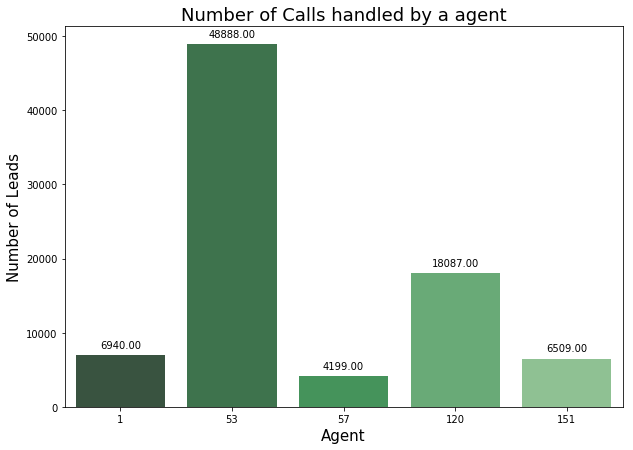

In [13]:
te = pd.DataFrame(number_of_calls_by_agents, index = range(0,1)).T
te.columns = ['col']
te.sort_values(by='col', inplace=True, ascending=False)
te.reset_index(inplace=True)

fig = plt.figure(figsize=(10,7))

groupedvalues = te.head()
pal = sns.color_palette("Greens_d", len(groupedvalues))
rank = groupedvalues["col"].argsort().argsort() 
g=sns.barplot(x='index',y='col',data=groupedvalues, palette=np.array(pal[::-1])[rank])
plt.title("Number of Calls handled by a agent", fontsize=18)
plt.xlabel("Agent", fontsize=15)
plt.ylabel("Number of Leads", fontsize=15)
for p in g.patches:
    g.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),
               ha = 'center',
               va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

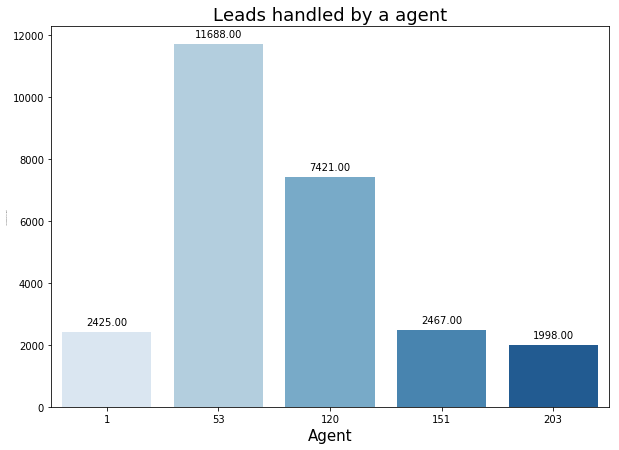

In [122]:
#agent_to_lead
agTl = pd.DataFrame(agent_to_lead, index = range(0,1)).T
agTl.columns = ['col']
agTl.sort_values(by='col', inplace=True, ascending=False)
agTl.reset_index(inplace=True)

fig = plt.figure(figsize=(10,7))

groupedvalues = agTl.head()
pal = sns.color_palette("Blues", len(groupedvalues))
rank = groupedvalues["col"].argsort().argsort() 
g=sns.barplot(x='index',y='col',data=groupedvalues, palette=np.array(pal[::-1])[rank])

plt.title("Leads handled by a agent", fontsize=18)
plt.xlabel("Agent", fontsize=15)
plt.ylabel("Leads handled by these Agents", fontsize=1)

for p in g.patches:
    g.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),
               ha = 'center',
               va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

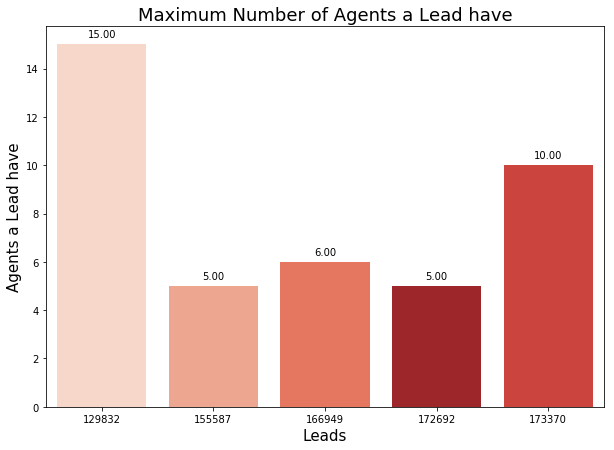

In [15]:
#lead_to_agent
te = pd.DataFrame(lead_to_agent, index = range(0,1)).T
te.columns = ['col']
te.sort_values(by='col', inplace=True, ascending=False)
te.reset_index(inplace=True)

fig = plt.figure(figsize=(10,7))

groupedvalues = te.head()
pal = sns.color_palette("Reds", len(groupedvalues))
rank = groupedvalues["col"].argsort().argsort() 
g=sns.barplot(x='index',y='col',data=groupedvalues, palette=np.array(pal[::-1])[rank])
plt.title("Maximum Number of Agents a Lead have", fontsize=18)
plt.xlabel("Leads", fontsize=15)
plt.ylabel("Agents a Lead have", fontsize=15)
for p in g.patches:
    g.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),
               ha = 'center',
               va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

In [18]:
def get_datetime(x):
    return datetime.datetime(int(x.call_created_year),
                             int(x.call_created_month),1,
                             int(x.call_created_hour))
data_compare_within_agents_hr = pd.pivot_table(df, values='duration', index=['call_created_year',
                                                                          'call_created_month',
                                                                          'call_created_hour',
                                                                          'userId'], aggfunc=[np.sum,
                                                                                              np.mean,
                                                                                              'count'])

data_compare_within_agents_hr.columns = ['_'.join(col) for col in data_compare_within_agents_hr.columns]
data_compare_within_agents_hr.reset_index(inplace=True)
print(data_compare_within_agents_hr.shape)

data_compare_within_agents_hr["datetime"] = data_compare_within_agents_hr.apply(get_datetime, axis=1)
data_compare_within_agents_hr.head()

(13110, 7)


,call_created_year,call_created_month,call_created_hour,userId,sum_duration,mean_duration,count_duration
0,2017,12,17,57,63,63.00,1
1,2017,12,18,59,171,171.00,1
2,2017,12,18,88,0,0.00,1
3,2017,12,19,72,137,137.00,1
4,2018,1,0,16,3043,760.75,4


In [101]:
for i in data_compare_within_agents_hr.call_created_year.unique():
    tem = data_compare_within_agents_hr[ data_compare_within_agents_hr.call_created_year == i ]
    
    for j in tem.call_created_month.unique():
        tempp = tem[ tem.call_created_month == j ]
        tempp.sort_values(by='count_duration', inplace=True, ascending=False)
        x = tempp.head(1)
        print("The user with the most calls in ",x.call_created_month.values, " month of year ",
              x.call_created_year.values," is ",
              x.userId.values," with ",
              x.count_duration.values, " calls, averaging at ",
             x.mean_duration.values," secs in the hour",x.call_created_hour.values)
        print("** ** ** **\n")

The user with the most calls in  [12]  month of year  [2017]  is  [57]  with  [1]  calls, averaging at  [63.]  secs in the hour [17]
** ** ** **

The user with the most calls in  [1]  month of year  [2018]  is  [53]  with  [228]  calls, averaging at  [20.87719298]  secs in the hour [14]
** ** ** **

The user with the most calls in  [2]  month of year  [2018]  is  [53]  with  [543]  calls, averaging at  [11.77348066]  secs in the hour [15]
** ** ** **

The user with the most calls in  [3]  month of year  [2018]  is  [53]  with  [338]  calls, averaging at  [15.87278107]  secs in the hour [14]
** ** ** **

The user with the most calls in  [4]  month of year  [2018]  is  [53]  with  [780]  calls, averaging at  [11.93846154]  secs in the hour [14]
** ** ** **

The user with the most calls in  [5]  month of year  [2018]  is  [53]  with  [710]  calls, averaging at  [11.34507042]  secs in the hour [14]
** ** ** **

The user with the most calls in  [6]  month of year  [2018]  is  [53]  with  [7

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

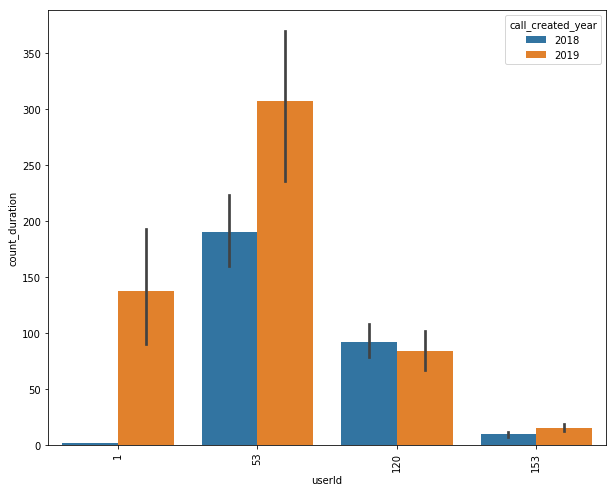

In [66]:
fig = plt.figure(figsize=(10,8))
sns.barplot(x="userId", y="count_duration", hue="call_created_year",
            data=data_compare_within_agents_hr[(data_compare_within_agents_hr['userId']==53)|(data_compare_within_agents_hr['userId']==1)|(data_compare_within_agents_hr['userId']==120)|(data_compare_within_agents_hr['userId']==153)|(data_compare_within_agents_hr['userId']==120)])

In [118]:
def get_datetime2(x):
    return datetime.datetime(int(x.call_created_year),
                             int(x.call_created_month),1,0)
data_compare_within_agents = pd.pivot_table(df, values='duration', index=['call_created_year', 'call_created_month', 'userId'],
                                            aggfunc=[np.sum,np.mean,'count'])

data_compare_within_agents.columns = ['_'.join(col) for col in data_compare_within_agents.columns]
data_compare_within_agents.reset_index(inplace=True)
data_compare_within_agents["datetime"] = data_compare_within_agents.apply(get_datetime2, axis=1)
print(data_compare_within_agents.shape)
data_compare_within_agents.head()

(1448, 7)


,call_created_year,call_created_month,userId,sum_duration,mean_duration,count_duration,datetime
0,2017,12,57,63,63.0,1,2017-12-01
1,2017,12,59,171,171.0,1,2017-12-01
2,2017,12,72,137,137.0,1,2017-12-01
3,2017,12,88,0,0.0,1,2017-12-01
4,2018,1,1,0,0.0,3,2018-01-01


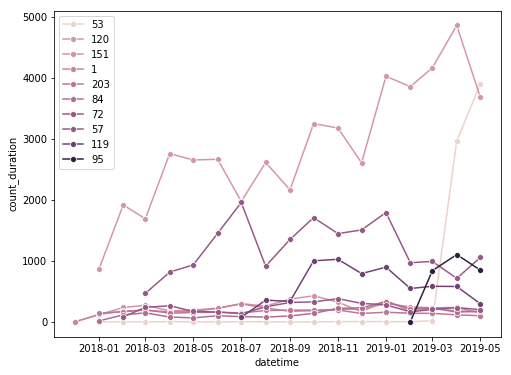

In [148]:
fig = plt.figure(figsize=(8,6))
temp_data = data_compare_within_agents[(data_compare_within_agents["userId"]==53)|(data_compare_within_agents["userId"]==120)|(data_compare_within_agents["userId"]==151)|(data_compare_within_agents["userId"]==1)|(data_compare_within_agents["userId"]==203)|(data_compare_within_agents["userId"]==84)|(data_compare_within_agents["userId"]==72)|(data_compare_within_agents["userId"]==57)|(data_compare_within_agents["userId"]==119)|(data_compare_within_agents["userId"]==95)]
sns.lineplot(x="datetime", y="count_duration", 
             data=temp_data,
             marker='o', color='mediumvioletred', hue='userId')
plt.legend(labels=agTl['index'][:10].values)

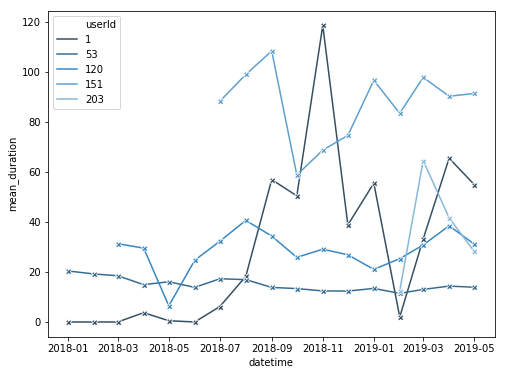

In [146]:
fig = plt.figure(figsize=(8,6))
temp_data = data_compare_within_agents[(data_compare_within_agents["userId"]==53)|(data_compare_within_agents["userId"]==120)|(data_compare_within_agents["userId"]==151)|(data_compare_within_agents["userId"]==1)|(data_compare_within_agents["userId"]==203)]

sns.lineplot(x="datetime", y="mean_duration", 
             data=temp_data,
             marker='X', palette = sns.color_palette("Blues_d", n_colors=5), hue='userId')
#plt.legend(labels=agTl['index'][:5].values)

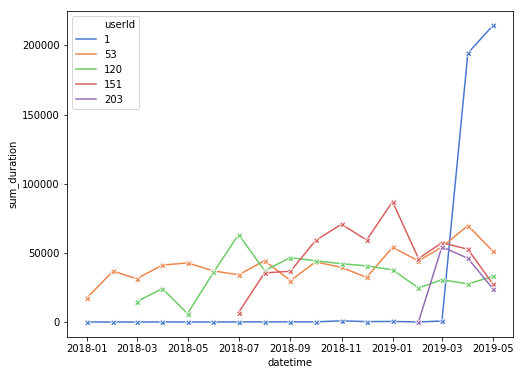

In [145]:
fig = plt.figure(figsize=(8,6))
sns.lineplot(x="datetime", y="sum_duration", 
             data=temp_data,
             marker='X', palette = sns.color_palette("muted", n_colors=5), hue='userId')


In [20]:
data_comp_agents_with_leads = pd.pivot_table(df, values='duration', index=['call_created_year', 'call_created_month', 'userId', 'personId'],
                                             aggfunc=[np.sum,np.mean,'count',np.median,np.max,np.min])

data_comp_agents_with_leads.columns = ['_'.join(col) for col in data_comp_agents_with_leads.columns]
data_comp_agents_with_leads.reset_index(inplace=True)

data_comp_agents_with_leads.head()

,call_created_year,call_created_month,userId,personId,sum_duration,mean_duration,count_duration,median_duration,amax_duration,amin_duration
0,2017,12,57,129572,63,63.0,1,63.0,63,63
1,2017,12,59,129575,171,171.0,1,171.0,171,171
2,2017,12,72,129576,137,137.0,1,137.0,137,137
3,2017,12,88,129570,0,0.0,1,0.0,0,0
4,2018,1,1,130440,0,0.0,1,0.0,0,0


In [149]:
df_year_data = pd.pivot_table(df, values='duration', index=['call_created_year', 'userId'],
                                             aggfunc=[np.sum,np.mean,'count'])

df_year_data.columns = ['_'.join(col) for col in df_year_data.columns]
df_year_data.reset_index(inplace=True)

df_year_data.head()

,call_created_year,userId,sum_duration,mean_duration,count_duration
0,2017,57,63,63.0,1
1,2017,59,171,171.0,1
2,2017,72,137,137.0,1
3,2017,88,0,0.0,1
4,2018,-1,2,2.0,1


In [155]:
for i in df_year_data.call_created_year.unique():
    print("Market share in year ",i, " per agent")
    df_temp = df_year_data[df_year_data.call_created_year==i]
    total_sec = df_temp.sum_duration.sum()
    total_calls = df_temp.count_duration.sum()
    df_temp["average_share_duration"] = df_temp.apply(lambda x:x.sum_duration/total_sec, axis=1)
    df_temp["average_share_calls"] = df_temp.apply(lambda x:x.count_duration/total_calls, axis=1)
    print(df_temp.sort_values(by=['average_share_duration'],ascending=False).head())
    print(df_temp.sort_values(by=['average_share_calls'],ascending=False).head())


Market share in year  2017  per agent
   call_created_year  userId  sum_duration  mean_duration  count_duration  \
1               2017      59           171          171.0               1   
2               2017      72           137          137.0               1   
0               2017      57            63           63.0               1   
3               2017      88             0            0.0               1   

   average_share_duration  average_share_calls  
1                0.460916                 0.25  
2                0.369272                 0.25  
0                0.169811                 0.25  
3                0.000000                 0.25  
   call_created_year  userId  sum_duration  mean_duration  count_duration  \
0               2017      57            63           63.0               1   
1               2017      59           171          171.0               1   
2               2017      72           137          137.0               1   
3               2017   

MovieWriter imagemagick unavailable. Trying to use pillow instead.


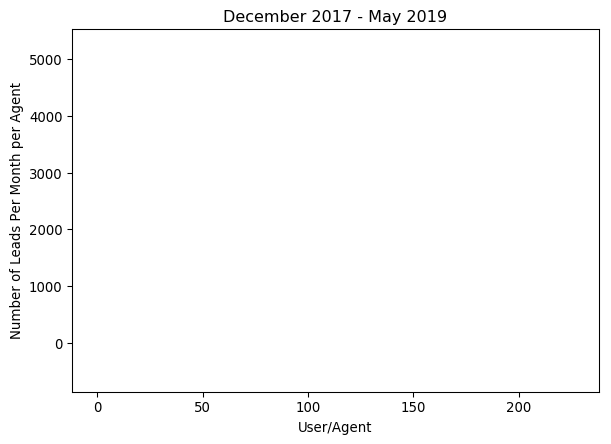

In [55]:
fig = plt.figure(figsize=(680/96, 480/96), dpi=96)
camera = Camera(fig)

for i in data_compare_within_agents.call_created_year.unique():
    tem = data_compare_within_agents[ data_compare_within_agents.call_created_year == i ]
    
    for j in tem.call_created_month.unique():
        tempp = tem[ tem.call_created_month == j ]
        tempp.sort_values(by='count_duration', inplace=True, ascending=False)
        
        # Change color with c and alpha. I map the color to the X axis value.
        tmp=tempp.head(10)
        t = plt.scatter(tmp['userId'], tmp['count_duration'] , s=tmp['userId']*50 ,
                    c=tmp['userId'],
                    cmap="Reds", alpha=0.6, edgecolors="white", linewidth=2)

        plt.xlabel("User/Agent")
        plt.ylabel("Number of Leads Per Month per Agent")
        plt.title("December 2017 - May 2019")
        z = list(tmp['userId'].values)
        y = list(tmp['count_duration'].values)
        for i, txt in enumerate(z):
            plt.annotate(txt, (z[i], y[i]))
        camera.snap()

animation = camera.animate(1200)
animation.save('monthly_top_10.gif', writer = 'imagemagick')